Train set: (400, 2) (400,)
Validation set: (100, 2) (100,)
Test set (noise=0.2): (500, 2)
Test set (noise=0.1): (500, 2)
Test set (noise=0.3): (500, 2)


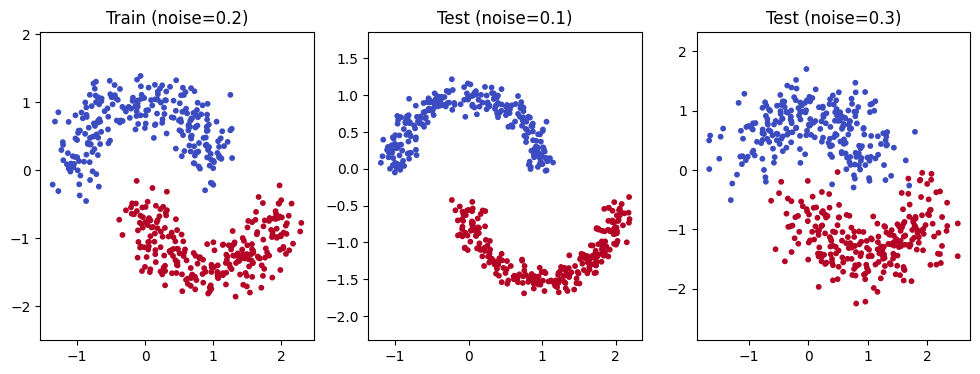

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

SEED = 1337
torch.manual_seed(SEED)



def make_moons_custom(n_samples=100, noise=0.1, random_state=None):
    if random_state is not None:
        rng = np.random.default_rng(random_state)
    else:
        rng = np.random.default_rng()

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    # Outer arc (upper moon)
    theta_out = rng.uniform(0, np.pi, n_samples_out)
    x_outer = np.c_[np.cos(theta_out), np.sin(theta_out)]

    # Inner arc (lower moon, shifted right)
    theta_in = rng.uniform(0, np.pi, n_samples_in)
    x_inner = np.c_[1 - np.cos(theta_in), -np.sin(theta_in) - 0.5]

    # Combine both moons
    X = np.vstack([x_outer, x_inner])
    y = np.hstack([np.zeros(n_samples_out, dtype=int), np.ones(n_samples_in, dtype=int)])

    # Add Gaussian noise
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

X_train_raw, y_train = make_moons_custom(500, noise=0.2, random_state=SEED)
X_test_raw, y_test = make_moons_custom(500, noise=0.2, random_state=SEED + 1)

# Additional noisy test sets for robustness
X_test_noise01, y_test01 = make_moons_custom(500, noise=0.1, random_state=SEED + 2)
X_test_noise03, y_test03 = make_moons_custom(500, noise=0.3, random_state=SEED + 3)


scaler = StandardScaler().fit(X_train_raw)

X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
X_test01 = scaler.transform(X_test_noise01)
X_test03 = scaler.transform(X_test_noise03)



X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

print("Train set:", X_train_main.shape, y_train_main.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set (noise=0.2):", X_test.shape)
print("Test set (noise=0.1):", X_test01.shape)
print("Test set (noise=0.3):", X_test03.shape)

plt.figure(figsize=(12,4))
for i, (X, y, title) in enumerate([
    (X_train_raw, y_train, "Train (noise=0.2)"),
    (X_test_noise01, y_test01, "Test (noise=0.1)"),
    (X_test_noise03, y_test03, "Test (noise=0.3)")
]):
    plt.subplot(1,3,i+1)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=10)
    plt.title(title)
    plt.axis('equal')
plt.show()


Epoch 000 | Train Loss: 0.6785 | Val Loss: 0.6490
Epoch 020 | Train Loss: 0.0985 | Val Loss: 0.1095
Epoch 040 | Train Loss: 0.0236 | Val Loss: 0.0133
Epoch 060 | Train Loss: 0.0176 | Val Loss: 0.0048
Epoch 080 | Train Loss: 0.0130 | Val Loss: 0.0032


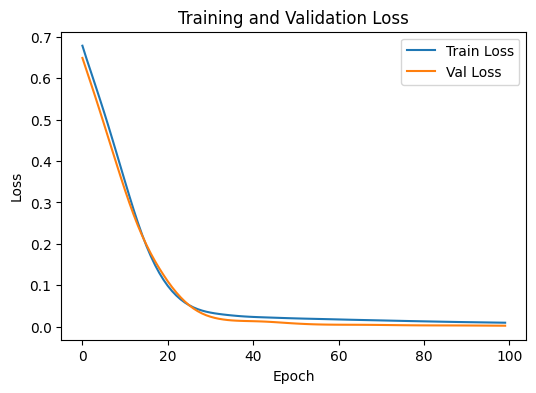


=== Test AUROC scores ===
Noise = 0.1: 1.0000
Noise = 0.2: 1.0000
Noise = 0.3: 0.9995


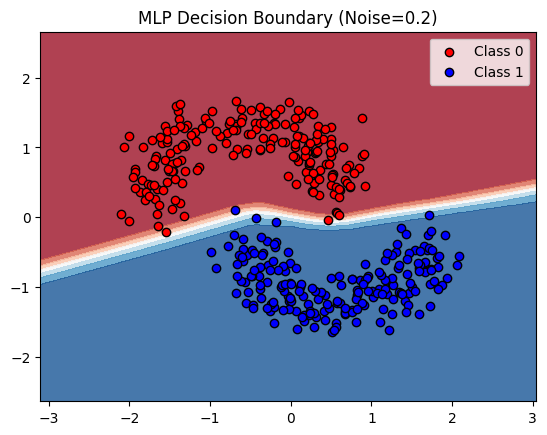

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


def to_tensor(x, y):
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train_t, y_train_t = to_tensor(X_train_main, y_train_main)
X_val_t, y_val_t = to_tensor(X_val, y_val)
X_test_t, y_test_t = to_tensor(X_test, y_test)
X_test01_t, y_test01_t = to_tensor(X_test01, y_test01)
X_test03_t, y_test03_t = to_tensor(X_test03, y_test03)


class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


def train_mlp_early_stopping(model, X_train, y_train, X_val, y_val, lr=0.01, patience=50, max_epochs=100):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = np.inf
    best_state = None
    wait = 0

    train_losses, val_losses = [], []

    for epoch in range(max_epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
        train_loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Early stopping check
        if val_loss.item() < best_val_loss - 1e-6:
            best_val_loss = val_loss.item()
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1

        # Print progress
        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        if wait >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

    # Restore best model weights
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, train_losses, val_losses

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    model.eval()
    y = y.ravel()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid).numpy().reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', edgecolor='k', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', edgecolor='k', label='Class 1')
    plt.title(title)
    plt.legend()
    plt.show()


model = MLP()
model, train_losses, val_losses = train_mlp_early_stopping(
    model, X_train_t, y_train_t, X_val_t, y_val_t, lr=0.01, patience=50
)


plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


def evaluate_auc(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X).numpy().flatten()
    return roc_auc_score(y.numpy(), preds)

auc_01 = evaluate_auc(model, X_test01_t, y_test01_t)
auc_02 = evaluate_auc(model, X_test_t, y_test_t)
auc_03 = evaluate_auc(model, X_test03_t, y_test03_t)

print("\n=== Test AUROC scores ===")
print(f"Noise = 0.1: {auc_01:.4f}")
print(f"Noise = 0.2: {auc_02:.4f}")
print(f"Noise = 0.3: {auc_03:.4f}")

plot_decision_boundary(model, X_train_main, y_train_main, title="MLP Decision Boundary (Noise=0.2)")



In [3]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_params)


Total trainable parameters: 337



λ = 1e-06
Validation AUROC: 0.9836
  layer1.weight: 56.25% zeros
  layer2.weight: 51.95% zeros
  out.weight: 31.25% zeros

λ = 3e-06
Validation AUROC: 1.0000
  layer1.weight: 50.00% zeros
  layer2.weight: 54.69% zeros
  out.weight: 43.75% zeros

λ = 1e-05
Validation AUROC: 1.0000
  layer1.weight: 50.00% zeros
  layer2.weight: 43.75% zeros
  out.weight: 75.00% zeros

λ = 3e-05
Validation AUROC: 0.9992
  layer1.weight: 53.12% zeros
  layer2.weight: 56.25% zeros
  out.weight: 56.25% zeros

λ = 1e-04
Validation AUROC: 1.0000
  layer1.weight: 59.38% zeros
  layer2.weight: 46.48% zeros
  out.weight: 43.75% zeros

λ = 3e-04
Validation AUROC: 1.0000
  layer1.weight: 46.88% zeros
  layer2.weight: 54.69% zeros
  out.weight: 68.75% zeros


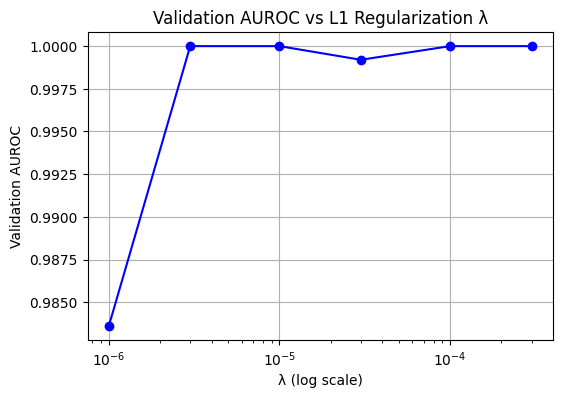


Best λ selected (based on validation AUROC): 3e-06

=== Final Test Performance ===
Noise=0.2 (Main Test):  AUROC = 0.9993
Noise=0.1 (Low Noise):  AUROC = 0.9999
Noise=0.3 (High Noise): AUROC = 0.9964


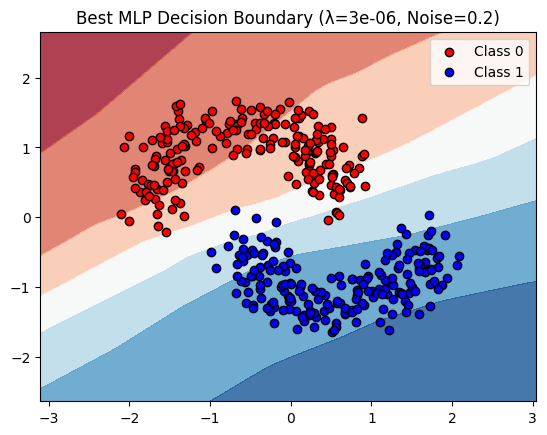

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


def to_tensor(x, y):
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)



X_train_t, y_train_t = to_tensor(X_train_main, y_train_main)
X_val_t, y_val_t = to_tensor(X_val, y_val)

X_test_main_t, y_test_main_t = to_tensor(X_test, y_test)
X_test_low_t, y_test_low_t = to_tensor(X_test01, y_test01)
X_test_high_t, y_test_high_t = to_tensor(X_test03, y_test03)


class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.sigmoid(self.out(x))
        return x



def train_with_l1(model, X_train, y_train, X_val, y_val, lam=1e-5, lr=1e-3, patience=30, max_epochs=100):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = np.inf
    best_state = None
    wait = 0

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        base_loss = criterion(y_pred, y_train)

        # L1 regularization term
        l1_loss = sum(torch.sum(torch.abs(p)) for n, p in model.named_parameters() if "weight" in n)
        total_loss = base_loss + lam * l1_loss

        total_loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val)

        if val_loss.item() < best_val_loss - 1e-6:
            best_val_loss = val_loss.item()
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model



def compute_sparsity(model):
    sparsities = {}
    for name, param in model.named_parameters():
        if "weight" in name:
            num_zero = torch.sum((param - 0) <= 0.001).item()
            total = param.numel()
            sparsities[name] = num_zero / total * 100
    return sparsities


def evaluate_auc(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X).numpy().flatten()
    return roc_auc_score(y.numpy(), preds)


lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_aurocs = []
sparsity_records = []

for lam in lambdas:
    model = MLP()
    model = train_with_l1(model, X_train_t, y_train_t, X_val_t, y_val_t, lam=lam, lr=1e-3)
    auc_val = evaluate_auc(model, X_val_t, y_val_t)
    sparsity = compute_sparsity(model)
    val_aurocs.append(auc_val)
    sparsity_records.append(sparsity)

    print(f"\nλ = {lam:.0e}")
    print(f"Validation AUROC: {auc_val:.4f}")
    for layer, sp in sparsity.items():
        print(f"  {layer}: {sp:.2f}% zeros")

plt.figure(figsize=(6, 4))
plt.semilogx(lambdas, val_aurocs, marker='o', color='blue')
plt.title("Validation AUROC vs L1 Regularization λ")
plt.xlabel("λ (log scale)")
plt.ylabel("Validation AUROC")
plt.grid(True)
plt.show()


best_idx = np.argmax(val_aurocs)
best_lambda = lambdas[best_idx]
print(f"\nBest λ selected (based on validation AUROC): {best_lambda:.0e}")

# --- Retrain best model on TRAIN + VAL combined ---
X_train_full = torch.cat([X_train_t, X_val_t], dim=0)
y_train_full = torch.cat([y_train_t, y_val_t], dim=0)

best_model = MLP()
best_model = train_with_l1(best_model, X_train_full, y_train_full, X_val_t, y_val_t, lam=best_lambda, lr=1e-3)


print("\n=== Final Test Performance ===")
auc_main = evaluate_auc(best_model, X_test_main_t, y_test_main_t)
auc_low = evaluate_auc(best_model, X_test_low_t, y_test_low_t)
auc_high = evaluate_auc(best_model, X_test_high_t, y_test_high_t)

print(f"Noise=0.2 (Main Test):  AUROC = {auc_main:.4f}")
print(f"Noise=0.1 (Low Noise):  AUROC = {auc_low:.4f}")
print(f"Noise=0.3 (High Noise): AUROC = {auc_high:.4f}")


plot_decision_boundary(best_model, X_train_main, y_train_main,
                       title=f"Best MLP Decision Boundary (λ={best_lambda:.0e}, Noise=0.2)")



1. Sparsity:
L1 regularization introduces a penalty proportional to the absolute value of the weights, encouraging many parameters to become exactly or nearly zero. This leads to a sparse network, where only a subset of neurons and connections significantly contribute to the decision. In contrast, the plain MLP (without L1) keeps most weights active, resulting in a denser model.

2. Boundary Smoothness and Jaggedness:
Due to sparsity, the L1-regularized model tends to simplify the learned function, producing a smoother and more linear decision boundary. The model avoids overfitting small fluctuations or noise in the data, hence the boundary is less jagged.
In contrast, the plain MLP exhibits a more complex and wavy boundary, capturing fine variations and possibly overfitting the dataset.

In [5]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_params)


Total trainable parameters: 337


L2=1.0e-06 -> Validation AUROC: 1.0000
L2=3.0e-06 -> Validation AUROC: 1.0000
L2=1.0e-05 -> Validation AUROC: 1.0000
L2=3.0e-05 -> Validation AUROC: 1.0000
L2=1.0e-04 -> Validation AUROC: 1.0000
L2=3.0e-04 -> Validation AUROC: 0.9580
L2=1.0e-03 -> Validation AUROC: 0.9948

✅ Best L2: 1.0e-06 (Val AUROC=1.0000)


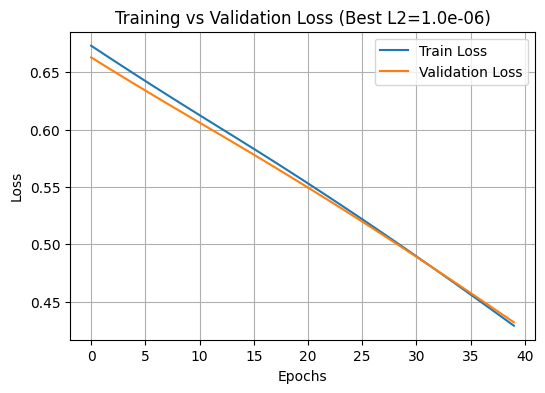

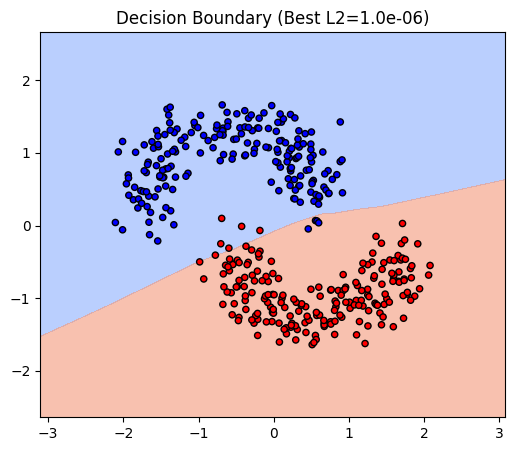


 Robustness Evaluation:
Test AUROC (noise=0.1): 0.9999
Test AUROC (noise=0.2): 0.9992
Test AUROC (noise=0.3): 0.9972


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

class MLP_L2(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


def train_mlp_l2(model, X_train, y_train, X_val, y_val,
                 lr=1e-3, weight_decay=0.0, epochs=40, patience=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_t)
            val_loss = criterion(y_val_pred, y_val_t).item()

        train_losses.append(loss.item())
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses



l2_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
val_aurocs = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for l2_val in l2_grid:
    model = MLP_L2()
    model, train_losses, val_losses = train_mlp_l2(
        model, X_train_main, y_train_main, X_val, y_val,
        weight_decay=l2_val
    )

    model.eval()
    with torch.no_grad():
        y_val_pred = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
    auc = roc_auc_score(y_val, y_val_pred)
    val_aurocs.append(auc)
    print(f"L2={l2_val:.1e} -> Validation AUROC: {auc:.4f}")

best_idx = np.argmax(val_aurocs)
best_l2 = l2_grid[best_idx]
print(f"\n✅ Best L2: {best_l2:.1e} (Val AUROC={val_aurocs[best_idx]:.4f})")


best_model = MLP_L2()
best_model, train_losses, val_losses = train_mlp_l2(
    best_model, X_train_main, y_train_main, X_val, y_val,
    weight_decay=best_l2
)

# Plot training and validation loss
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title(f"Training vs Validation Loss (Best L2={best_l2:.1e})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        preds = model(torch.tensor(grid, dtype=torch.float32).to(device)).cpu().numpy().reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], alpha=0.6, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=20, edgecolor='k')
    plt.title(title)
    plt.show()


# Visualize boundary on training set (noise=0.2)
plot_decision_boundary(best_model, X_train_main, y_train_main,
                       title=f"Decision Boundary (Best L2={best_l2:.1e})")


test_sets = [
    ("0.1", X_test01, y_test01),
    ("0.2", X_test, y_test),
    ("0.3", X_test03, y_test03)
]

print("\n Robustness Evaluation:")
for noise_label, X_noise, y_noise in test_sets:
    best_model.eval()
    with torch.no_grad():
        y_pred = best_model(torch.tensor(X_noise, dtype=torch.float32).to(device)).cpu().numpy()
    auc = roc_auc_score(y_noise, y_pred)
    print(f"Test AUROC (noise={noise_label}): {auc:.4f}")


1. Smoothness:
L2 regularization (also known as weight decay) penalizes the square of the magnitude of the weights, discouraging very large parameter values. This leads to smoother and more stable model predictions, as the network avoids learning overly sharp transitions or complex patterns. Consequently, the decision boundary appears gentle and continuous, as seen in the plot.

2. Margin and Generalization:
By reducing the magnitude of the weights, L2 regularization effectively increases the margin between classes — the model prefers boundaries that separate classes with some buffer zone rather than tightly fitting each data cluster. This helps improve generalization and robustness to noise, preventing the model from overfitting small local variations.

In [7]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", total_params)


Total trainable parameters: 1185


Epoch 0: Loss = 0.6498
Epoch 100: Loss = 0.2560
Epoch 200: Loss = 0.1750
Epoch 300: Loss = 0.1347
Epoch 400: Loss = 0.1099
Epoch 500: Loss = 0.0932
Epoch 600: Loss = 0.0813
Epoch 700: Loss = 0.0723
Epoch 800: Loss = 0.0654
Epoch 900: Loss = 0.0599


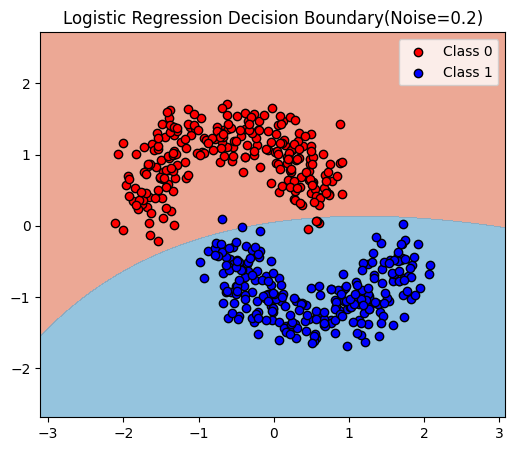

Accuracy (noise=0.1): 100.00%
Accuracy (noise=0.2): 99.60%
Accuracy (noise=0.3): 97.60%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.layer1 = nn.Linear(5, 1)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x))

model2 = MLP2()
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)


X_train_log = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)




def augment_features(X):
    x1 = X[:, 0].reshape(-1, 1)
    x2 = X[:, 1].reshape(-1, 1)
    x1_square = x1 ** 2
    x2_square = x2 ** 2
    x1_x2 = x1 * x2
    return torch.cat([X, x1_square, x2_square, x1_x2], dim=1)

X_train_aug = augment_features(X_train_log)


epochs = 1000
for epoch in range(epochs):
    y_pred = model2(X_train_aug)
    loss = criterion(y_pred, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    X = X.numpy()
    y = y.numpy().ravel()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    grid_aug = augment_features(grid)
    with torch.no_grad():
        Z = model(grid_aug).numpy().reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.7, cmap="RdBu")
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color="red", label="Class 0", edgecolor="k")
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color="blue", label="Class 1", edgecolor="k")
    plt.title(title)
    plt.legend()
    plt.show()


plot_decision_boundary(model2,X_train_log,y_train_t,title="Logistic Regression Decision Boundary(Noise=0.2)")


def evaluate_model(X_test_np, y_test_np, noise_label):
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_np, dtype=torch.float32).reshape(-1, 1)
    X_test_aug = augment_features(X_test_t)
    with torch.no_grad():
        y_pred = model2(X_test_aug)
    y_pred_label = (y_pred > 0.5).float()
    accuracy = (y_pred_label == y_test_t).sum().item() / y_test_t.size(0) * 100
    print(f"Accuracy (noise={noise_label}): {accuracy:.2f}%")


evaluate_model(X_test01, y_test01, 0.1)
evaluate_model(X_test, y_test, 0.2)
evaluate_model(X_test03, y_test03, 0.3)


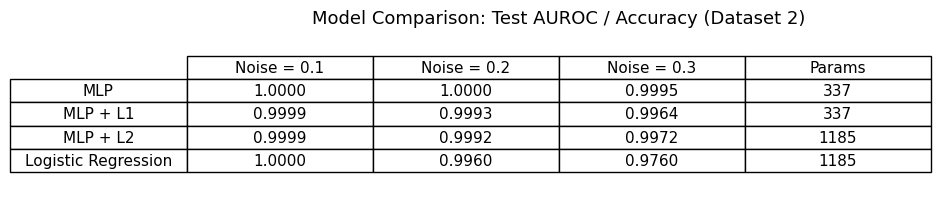

In [10]:
import matplotlib.pyplot as plt

# --- Model performance data (Dataset 2) ---
models = ["MLP", "MLP + L1", "MLP + L2", "Logistic Regression"]

noise_01 = [1.0000, 0.9999, 0.9999, 1.0000]
noise_02 = [1.0000, 0.9993, 0.9992, 0.9960]
noise_03 = [0.9995, 0.9964, 0.9972, 0.9760]
params = [337, 337, 1185, 1185]

# --- Prepare table data ---
table_data = []
for i in range(len(models)):
    table_data.append([
        f"{noise_01[i]:.4f}",
        f"{noise_02[i]:.4f}",
        f"{noise_03[i]:.4f}",
        str(params[i])
    ])

# --- Plot the table ---
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis("off")

columns = ["Noise = 0.1", "Noise = 0.2", "Noise = 0.3", "Params"]
table = ax.table(cellText=table_data, colLabels=columns, rowLabels=models,
                 loc="center", cellLoc="center", rowLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.4)

ax.set_title("Model Comparison: Test AUROC / Accuracy (Dataset 2)", fontsize=13, pad=10)
plt.show()
